# Regression Analysis - Using TheDataMentor Analysis Template


Author: Brandon T. Jackson of DataJackson, LLC. 

Initalized: 3/10/2020

The following workbook blends my experience as a Data Scientist over the last 5 years as well as a year of mentoring working professionals through a paid data science bootcamp. 



# Analysis Agenda

[Link to Step 1: Setup Analysis Environment](#step1) 

[Link to Step 2: Frame The Problem](#step2)

[Link to Step 3: Collect Data](#step3)

[Link to Step 4: Clean Data](#step4)

[Link to Step 5: Explore Data](#step5)

[Link to Step 6: Model Data](#step6)

[Link to Step 7: Validate Model](#step7)

[Link to Step 8: Productionize Model](#step8)

<a id='step1'></a>

# Step 1: Setup Analysis Environment

In [54]:
''' Import basic Moddules'''

import pandas as pd
import numpy as np

''' From sklearn import linear_model'''

import sklearn as stk
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.preprocessing import RobustScaler
import sklearn.datasets 
from sklearn.model_selection import KFold
from sklearn import linear_model


''' Stats packages'''
import scipy.stats as st
import statsmodels as sm
from statsmodels.tools.eval_measures import mse, rmse
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

'''visualization .'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
init_notebook_mode(connected = True) # Required to use plotly offline in jupyter notebook
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 

In [3]:
'''Display markdown formatted output like bold, italic bold etc.'''
from IPython.display import Markdown
def bold(string):
    display(Markdown(string))

<a id='step2'></a>

# Step 2: Frame The Problem

Frame the problem: Who is your client? What exactly is the client asking you to solve? How can you translate their ambiguous request into a concrete, well-defined problem?

1. Make a clear statement of the problem
2. List the assumptions about the problem (e.g. about the data).
3. Describe the motivation for solving the problem.
    - Describe the benefits of the solution (model or the predictions).
    - Describe how the solution will be used.
4. Map domain knowledge to a machine learning solution 
    - Describe how the problem is currently solved (if at all).
    - Describe how a subject matter expert would make manual predictions.
    - Describe how a programmer might hand code a classifier.

<a id='step3'></a>

# Step 3: Collect or Access Your Data

Collect the raw data needed to solve the problem: 
- Is this data already available? If so, what parts of the data are useful? 
- If not, what more data do you need? What kind of resources (time, money, infrastructure) would it take to collect this data in a usable form?

### For ease of use:

I am going to randomly generate data using sklearn dataset. Resources listed below:


Resource - Synthetic Data - https://towardsdatascience.com/synthetic-data-generation-a-must-have-skill-for-new-data-scientists-915896c0c1ae

Resource - Generate Regression Data - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

**Important: Once we add the outliers, the model only has 7% accuracy. Lets see if data transformations and removing outliers helps**

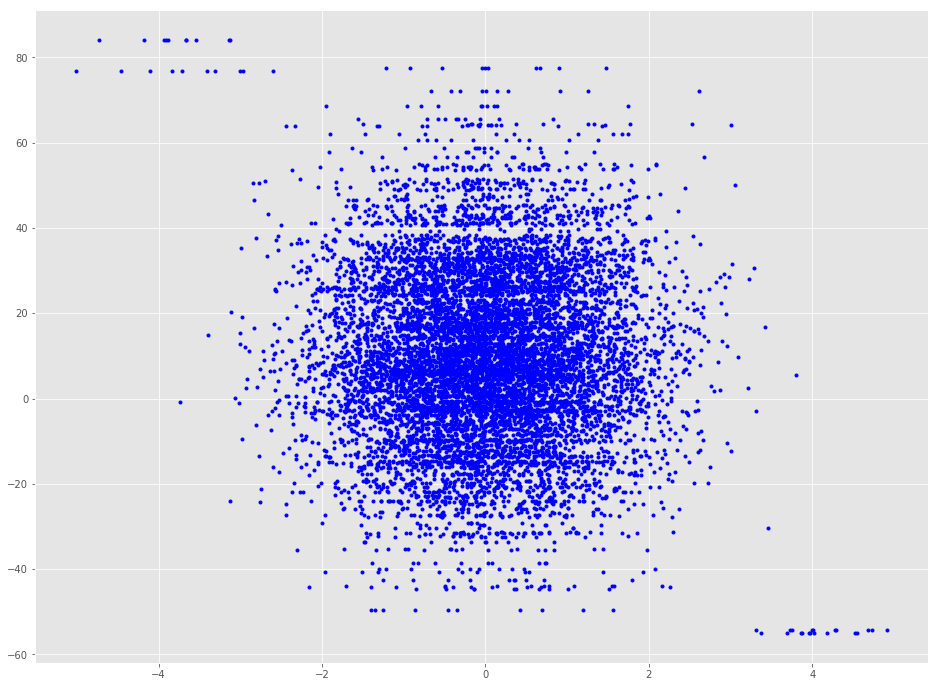

In [70]:
# Function to create regression data


''' Simulate Regression Data'''
rng = np.random.RandomState(0)
X, y =sklearn.datasets.make_regression(n_samples=1000, n_features=10, n_informative=4, n_targets=1, bias=-0.5, effective_rank=None, tail_strength=0.5, noise=0.8, shuffle=True, coef=False, random_state=None)

y = np.random.normal(10,20,1000)

'''

Going to comment out this code and come back later. 
I am adding it to build a more interpretatble analysis based on simulated data.

def PosNormal(mean, sigma):
    y = np.random.normal(10,20,1000)
    return(y if y>=0 else PosNormal(mean,sigma))

y = PosNormal(10,20)
'''
bold('**Important: Once we add the outliers, the model only has 7% accuracy. Lets see if data transformations and removing outliers helps**')

''' Add noise and outliers'''

# Add four strong outliers to the dataset.
X_outliers = rng.normal(0, 0.5, size=(4, 10))
y_outliers = rng.normal(0, 2.0, size=4)
X_outliers[:2, :] += X.max() + X.mean() / 4.
X_outliers[2:, :] += X.min() - X.mean() / 4.
y_outliers[:2] += y.min() - y.mean() / 4.
y_outliers[2:] += y.max() + y.mean() / 4.
X = np.vstack((X, X_outliers))
y = np.concatenate((y, y_outliers))
plt.plot(X, y, 'b.')


''' A secondary method to add outliers'''

n_outliers = 100
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 10))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Convert the array into a dataframe
X_df = pd.DataFrame(X)

X_df.columns = ['Variable_'+str(X_df+1) for X_df in range(X_df.shape[1])]
#pd.DataFrame(X_df).shape

y_df = pd.DataFrame(y)
#y_df.shape
y_df.columns = ['y']

frames = [X_df,y_df]

#frames = pd.concat([X_df,y_df], axis = 1)

# assign the regression data to df and then create column names
df = pd.concat(frames,axis = 1)


In [73]:
''' Testing out another method to generate random data'''
''' 

# WILL COME BACK AND UPDATE ##

import logging
__name__ = "DataSimulator"
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

import numpy as np
import pandas as pd

def generate_simulated_data(add_anomalies:bool=True, random_state:int=42):
    rnd_state = np.random.RandomState(random_state)
    time = np.linspace(0, 200, num=2000)
    pure = 20*np.sin(time/(2*np.pi))

    # concatenate on the second axis; this will allow us to mix different data 
    # distribution
    data = np.c_[pure]
    mu = np.mean(data)
    sd = np.std(data)
    logger.info(f"Data shape : {data.shape}. mu: {mu} with sd: {sd}")
    data_df = pd.DataFrame(data, columns=['Value'])
    data_df['Index'] = data_df.index.values

    # Adding gaussian jitter
    jitter = 0.3*rnd_state.normal(mu, sd, size=data_df.shape[0])
    data_df['with_jitter'] = data_df['Value'] + jitter

    index_further_away = None
    if add_anomalies:
        # As per the 68-95-99.7 rule(also known as the empirical rule) mu+-2*sd 
        # covers 95.4% of the dataset.
        # Since, anomalies are considered to be rare and typically within the 
        # 5-10% of the data; this filtering
        # technique might work 
        #for us(https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule)
        indexes_furhter_away = np.where(np.abs(data_df['with_jitter']) > (mu + 
         2*sd))[0]
        logger.info(f"Number of points further away : {len(indexes_furhter_away)}. Indexes: {indexes_furhter_away}")
        # Generate a point uniformly and embed it into the dataset
        random = rnd_state.uniform(0, 5, 1)
        data_df.loc[indexes_furhter_away, 'with_jitter'] += random*data_df.loc[indexes_furhter_away, 'with_jitter']
    return data_df, indexes_furhter_away
    
'''

' \n\n# WILL COME BACK AND UPDATE ##\n\nimport logging\n__name__ = "DataSimulator"\nlogging.basicConfig(level=logging.INFO)\nlogger = logging.getLogger(__name__)\n\nimport numpy as np\nimport pandas as pd\n\ndef generate_simulated_data(add_anomalies:bool=True, random_state:int=42):\n    rnd_state = np.random.RandomState(random_state)\n    time = np.linspace(0, 200, num=2000)\n    pure = 20*np.sin(time/(2*np.pi))\n\n    # concatenate on the second axis; this will allow us to mix different data \n    # distribution\n    data = np.c_[pure]\n    mu = np.mean(data)\n    sd = np.std(data)\n    logger.info(f"Data shape : {data.shape}. mu: {mu} with sd: {sd}")\n    data_df = pd.DataFrame(data, columns=[\'Value\'])\n    data_df[\'Index\'] = data_df.index.values\n\n    # Adding gaussian jitter\n    jitter = 0.3*rnd_state.normal(mu, sd, size=data_df.shape[0])\n    data_df[\'with_jitter\'] = data_df[\'Value\'] + jitter\n\n    index_further_away = None\n    if add_anomalies:\n        # As per the 6

generate_simulated_data()

In [7]:
y_df.describe()

,y
count,1004.000000
mean,8.834373
std,20.312985
min,-50.920965
25%,-5.089567
50%,7.971352
75%,22.660467
max,75.958850


In [8]:
'''Let"s take a quick look at the data'''

bold('**Preview of Test Data:**')
display(df.head(3))

**Preview of Test Data:**

,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Variable_10,y
0,3.882026,3.200079,3.489369,4.120447,3.933779,2.511361,3.475044,2.924321,2.948391,3.205299,2.559627
1,3.072022,3.727137,3.380519,3.060838,3.221932,3.166837,3.747040,2.897421,3.156534,2.572952,5.924739
2,1.723505,3.326809,3.432218,2.628917,4.134877,2.272817,3.022879,2.906408,3.766390,3.734679,-7.223148


In [9]:
bold('**Preview Descriptive statistics transposed:**')
display(df.describe().T)

**Preview Descriptive statistics transposed:**

,count,mean,std,min,25%,50%,75%,max
Variable_1,1004.0,0.338817,1.312446,-5.312745,-0.542144,0.218643,1.059469,4.862290
Variable_2,1004.0,0.308375,1.332092,-3.847169,-0.572322,0.150105,1.021323,4.707401
Variable_3,1004.0,0.244661,1.368929,-4.480143,-0.634833,0.122445,0.913209,4.469633
Variable_4,1004.0,0.276703,1.356626,-5.026649,-0.628310,0.103756,0.958659,5.100711
Variable_5,1004.0,0.294575,1.320831,-4.210206,-0.600904,0.178609,0.942201,4.914043
Variable_6,1004.0,0.252618,1.328576,-4.763433,-0.658121,0.041292,0.884730,4.206227
Variable_7,1004.0,0.291252,1.320182,-4.013371,-0.596827,0.152522,0.915741,4.727304
Variable_8,1004.0,0.251802,1.355627,-4.129842,-0.676980,0.116121,0.933367,4.128362
Variable_9,1004.0,0.382997,1.348344,-4.229914,-0.535310,0.253058,1.108357,4.297212
Variable_10,1004.0,0.270586,1.349371,-4.187402,-0.640722,0.075280,0.893377,4.190373


In [10]:
bold('**Preview of Predictor Variable:**')
y_df.head()

**Preview of Predictor Variable:**

,y
0,2.559627
1,5.924739
2,-7.223148
3,-1.952860
4,-0.719467


In [11]:
bold('**Check .info() to see if there are any missing variables:**')
df.info()

**Check .info() to see if there are any missing variables:**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 11 columns):
Variable_1     1004 non-null float64
Variable_2     1004 non-null float64
Variable_3     1004 non-null float64
Variable_4     1004 non-null float64
Variable_5     1004 non-null float64
Variable_6     1004 non-null float64
Variable_7     1004 non-null float64
Variable_8     1004 non-null float64
Variable_9     1004 non-null float64
Variable_10    1004 non-null float64
y              1004 non-null float64
dtypes: float64(11)
memory usage: 86.4 KB


<a id='step4'></a>

In [12]:
"""Let's first inspect how many kinds of data types that we have to deal with."""
bold('**Data types of our variables:**')
display(df.dtypes.value_counts())

**Data types of our variables:**

float64    11
dtype: int64

In [13]:
'''In case you have object data types, extract numerical variables first.'''
num_df = df.select_dtypes(include = ['int64', 'float64'])
bold('**Numerical variables:**')
display(num_df.head(3))
bold('**Name of numerical variables:**')
display(num_df.columns.values)



**Numerical variables:**

,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Variable_10,y
0,3.882026,3.200079,3.489369,4.120447,3.933779,2.511361,3.475044,2.924321,2.948391,3.205299,2.559627
1,3.072022,3.727137,3.380519,3.060838,3.221932,3.166837,3.747040,2.897421,3.156534,2.572952,5.924739
2,1.723505,3.326809,3.432218,2.628917,4.134877,2.272817,3.022879,2.906408,3.766390,3.734679,-7.223148


**Name of numerical variables:**

array(['Variable_1', 'Variable_2', 'Variable_3', 'Variable_4',
       'Variable_5', 'Variable_6', 'Variable_7', 'Variable_8',
       'Variable_9', 'Variable_10', 'y'], dtype=object)

# Step 4: Clean Data

Real, raw data is rarely usable out of the box. There are errors in data collection, corrupt records, missing values and many other challenges you will have to manage. You will first need to clean the data to convert it to a form that you can further analyze.


### Data Model:

 - Drop duplicate columns
 - Replace/drop missing values
 - Remove/ windsorize outliers
 - Remove unwanted string characters
    

### Science Model:

- Scaling: The preprocessed data may contain attributes with a mixtures of scales for various quantities such as dollars, kilograms and sales volume. Many machine learning methods like data attributes to have the same scale such as between 0 and 1 for the smallest and largest value for a given feature. Consider any feature scaling you may need to perform.
- Decomposition: There may be features that represent a complex concept that may be more useful to a machine learning method when split into the constituent parts. An example is a date that may have day and time components that in turn could be split out further. Perhaps only the hour of day is relevant to the problem being solved. consider what feature decompositions you can perform.
- Sampling: 


Resource: https://machinelearningmastery.com/how-to-prepare-data-for-machine-learning/

In [14]:
''' Handling Missing Data '''

' Handling Missing Data '

In [15]:
col_mask=df.isnull().any(axis=0)  # returns a boolean mask indicating np.nan values.

In [16]:
row_mask=df.isnull().any(axis=1) # return the rows where np.nan appeared

In [17]:
df.loc[row_mask,col_mask]  # by simple indexing you can flag all of your points that are np.nan.

""


In [18]:
# Now for this analysis, we are simply going to set all NaN to 0, but you could replance with mean or median. 

df.fillna(df.mean(), inplace=True)

In [19]:
df.describe()

,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Variable_10,y
count,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000,1004.000000
mean,0.338817,0.308375,0.244661,0.276703,0.294575,0.252618,0.291252,0.251802,0.382997,0.270586,8.834373
std,1.312446,1.332092,1.368929,1.356626,1.320831,1.328576,1.320182,1.355627,1.348344,1.349371,20.312985
min,-5.312745,-3.847169,-4.480143,-5.026649,-4.210206,-4.763433,-4.013371,-4.129842,-4.229914,-4.187402,-50.920965
25%,-0.542144,-0.572322,-0.634833,-0.628310,-0.600904,-0.658121,-0.596827,-0.676980,-0.535310,-0.640722,-5.089567
50%,0.218643,0.150105,0.122445,0.103756,0.178609,0.041292,0.152522,0.116121,0.253058,0.075280,7.971352
75%,1.059469,1.021323,0.913209,0.958659,0.942201,0.884730,0.915741,0.933367,1.108357,0.893377,22.660467
max,4.862290,4.707401,4.469633,5.100711,4.914043,4.206227,4.727304,4.128362,4.297212,4.190373,75.958850


<a id='step5'></a>

# Step 5: Explore Data 

Perform in-depth analysis (machine learning, statistical models, algorithms): This step is usually the meat of your project,where you apply all the cutting-edge machinery of data analysis to unearth high-value insights and predictions.

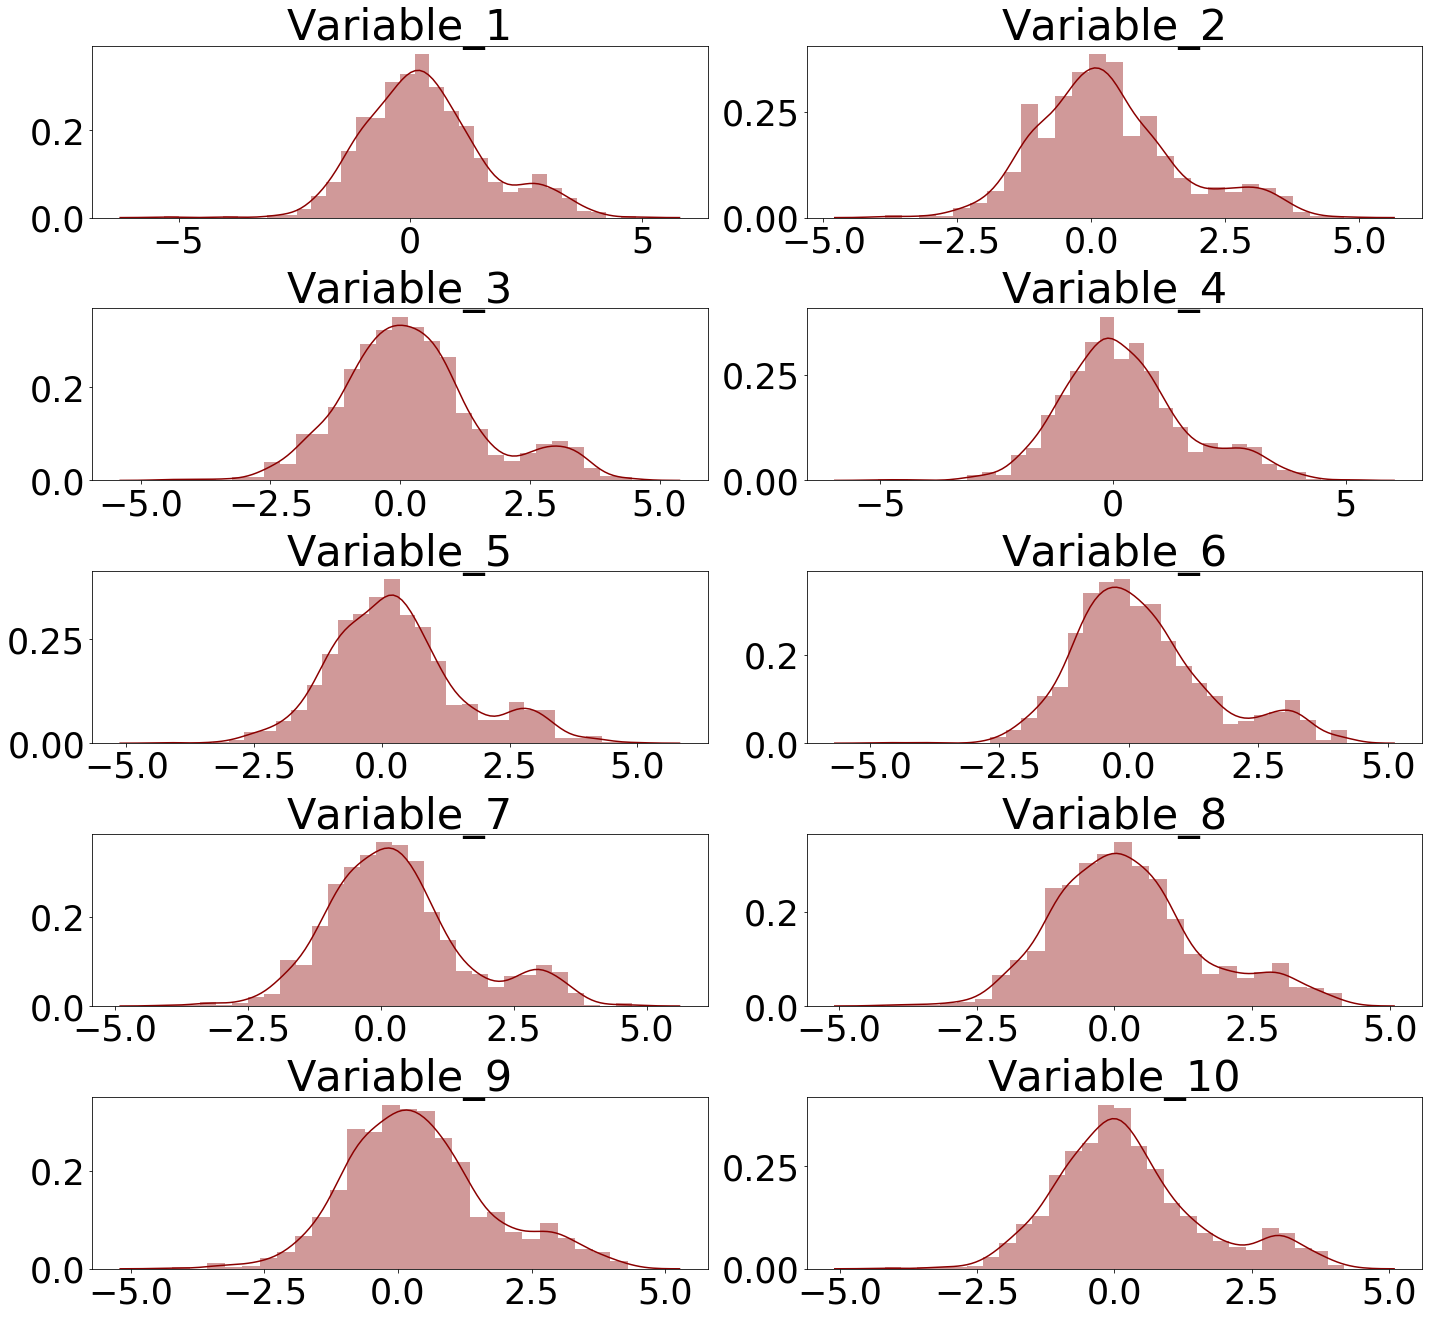

In [20]:
'''Plot histogram of numerical variables to validate pandas intuition.'''
''' Here we use  len(num_df.columns)//2 to assign the figure the number of rows'''

fig, axes = plt.subplots(nrows = len(num_df.columns)//2, ncols = 2, figsize = (20, 20))
for ax, column in zip(axes.flatten(), num_df.columns):
    sns.distplot(num_df[column].dropna(), ax = ax, color = 'darkred')
    ax.set_title(column, fontsize = 43)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 35)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 35)
    ax.set_xlabel('')
fig.tight_layout(rect = [0, 0.03, 1, 0.95])

In [21]:
''' Now, based on the above distributions'''
''' Identify and numeric variables that should be object variables'''
''' We will want to convert them into categorical'''

bold('**Important: If you see any categorical variables, uncomment and run the below code:**')

''' You will need to read in the colmn names'''

#num_df.loc[:,['Variable_10', 'Variable_2', 'Variable_3']] = num_df.loc[:,['Variable_10', 'Variable_2', 'Variable_3']].astype('object')

**Important: If you see any categorical variables, uncomment and run the below code:**

' You will need to read in the colmn names'

In [22]:
'''Function to plot bar chart'''
def bar_plot(x, y, title, yaxis, c_scale):
    trace = go.Bar(
    x = x,
    y = y,
    marker = dict(color = y, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    
    
'''Function to plot histogram'''
def plot_histogram(x, title, yaxis, color):
    trace = go.Histogram(x = x,
                        marker = dict(color = color))
    layout = go.Layout(hovermode= 'closest', title = title, yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)

In [23]:
#plot_histogram(num_df[['Variable_4']],'title','y' ,'aliceblue')

In [24]:
'''Now calculate and plot the skewness for rest of the explanetory variables.'''
skew_merged = pd.DataFrame(data = num_df.select_dtypes(include = ['int64', 'float64']).skew(), columns = ['Skewness'])
skew_merged_sorted = skew_merged.sort_values(ascending = False, by = 'Skewness')
bar_plot(skew_merged_sorted.index, skew_merged_sorted.Skewness, 'Skewness in Explanetory Variables', 'Skewness', 'Bluered')

### check the distribution of our Y variable

In [25]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (16.0, 12.0)
plt.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        #st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        #st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        #st.foldcauchy,st.foldnorm,st.frechet_r,st.frechet_l,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        #st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        #st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        #st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        #st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        #st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

Text(0, 0.5, 'Frequency')

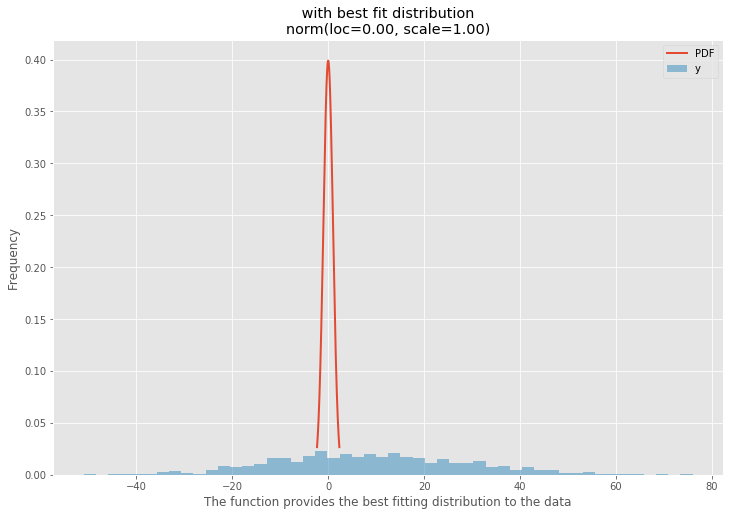

In [26]:

# Load data from statsmodels datasets
data = y_df


# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data, 200)
best_dist = getattr(st, best_fit_name)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)
data.plot(kind='hist', bins=50, normed=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
dist_str = '{}({})'.format(best_fit_name, param_str)

ax.set_title(u' with best fit distribution \n' + dist_str)
ax.set_xlabel(u'The function provides the best fitting distribution to the data')
ax.set_ylabel('Frequency')

### Find and remove outliers

There are a few methods for handling outliers, we will only work with one here, however, please research the following method to identify and resolve. 

- Box Plot (remove records that fall above/below the upper and lower whiskers)
- Scatter Plot 
- Z scores
- IQR
- Windsorization 

Resource: https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

In [27]:
''' We will use scipy stats and numpy'''

z = np.abs(st.zscore(df))

bold('**Preview of Z Score Labeles:**')
display(z)

**Preview of Z Score Labeles:**

array([[2.70104514, 2.17188028, 2.3714338 , ..., 1.90357335, 2.17595829,
        0.30905718],
       [2.0835658 , 2.56773944, 2.29187939, ..., 2.05801984, 1.70710124,
        0.14331152],
       [1.05556989, 2.26706428, 2.32966439, ..., 2.51054504, 2.56846993,
        0.79089925],
       ...,
       [2.83083692, 3.30398944, 3.00831717, ..., 2.78539553, 2.4339232 ,
        2.94319714],
       [4.30827668, 3.01767363, 2.81286316, ..., 2.71049384, 2.64859434,
        2.94590845],
       [3.27612467, 3.12111745, 3.45317932, ..., 3.42287243, 3.30539814,
        3.30615764]])

In [28]:
bold('**Let’s try and define a threshold to identify an outlier:**')

**Let’s try and define a threshold to identify an outlier:**

In [29]:
''' The first array contains the list of row numbers and second array respective column numbers'''
threshold = 3
display(np.where(z > 3))

(array([  49,   94,  113, 1000, 1000, 1000, 1000, 1000, 1001, 1001, 1001,
        1002, 1002, 1002, 1002, 1002, 1002, 1003, 1003, 1003, 1003, 1003,
        1003, 1003, 1003, 1003], dtype=int64),
 array([ 4,  3,  2,  0,  2,  3,  4,  6,  1,  2,  6,  0,  1,  3,  5,  6,  7,
         0,  1,  2,  3,  4,  5,  8,  9, 10], dtype=int64))

In [30]:
''' Define a new variable for outliers'''
''' The new variable will be called outlier_thresholds'''

outlier_threshold = np.where(z > 3)

In [31]:
total_outliers = len(outlier_threshold[0]) *len(outlier_threshold[1])

In [32]:
bold('**Let’s interpret the output:**')

print('So, the data point — {}th record on column {} is an outlier of {}.'.format(outlier_threshold[0][0],outlier_threshold[1][0],z[49][4]))

**Let’s interpret the output:**

So, the data point — 49th record on column 4 is an outlier of 3.0704590689679314.


In [33]:
bold('**How many outliers do we have?**')

#print('There are {} total outliers.'.format(total_outliers))

**How many outliers do we have?**

In [34]:
bold('**Now let"s remove the outliers**')


''' This can be done with the below code'''

new_df_o = df[(z < 3).all(axis=1)]

display(new_df_o.shape)

display(df.shape)

**Now let"s remove the outliers**

(997, 11)

(1004, 11)

### Feauture Scaling

In [35]:
'''Standarize numeric features with RobustScaler'''
'''Initialize robust scaler object.'''
robust_scl = RobustScaler()

'''Fit scaler object on train data.'''
robust_scl.fit(new_df_o)

'''Apply scaler object to both train and test data.'''
df_scaled = robust_scl.transform(new_df_o)

In [36]:
'''Retrive column names'''
df_scaled = pd.DataFrame(data = df_scaled, columns = new_df_o.columns, index = new_df_o.index)
# Pass the index of index df_merged_num, otherwise it will sum up the index.

In [37]:
df_scaled.head()

,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Variable_10,y
0,2.293597,1.927026,2.198301,2.561064,2.458874,1.615342,2.217740,1.765442,1.654836,2.043284,-0.195784
1,1.786736,2.259890,2.127239,1.885493,1.993912,2.042208,2.398993,1.748542,1.782119,1.630620,-0.074112
2,0.942900,2.007063,2.160990,1.610115,2.590227,1.459995,1.916426,1.754188,2.155055,2.388752,-0.549498
3,1.790147,1.920080,1.589031,1.215260,1.735328,1.984468,2.311101,2.190677,1.567968,1.810667,-0.358941
4,1.413601,1.352258,1.321862,2.468579,1.682505,1.790915,1.483760,2.057211,1.192935,1.839891,-0.314345


<a id='step6'></a>

# Step 6: Model Data

Document Model Assumptions:
    
    
    
    
    
Resource: https://towardsdatascience.com/all-the-annoying-assumptions-31b55df246c3

## split dataset into train and test data

In [55]:

#split dataset into train and test data
#train , test = train_test_split(df, test_size = 0.4)

#x_train = train.drop('y')
#y_train = train['y']

#x_test = test.drop('y')
#y_test = test['y']


x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 465)

## Validate Model Assumptions

We create a function to validate the below assumptions for OLS regression. 

 - Assumption 1: Linear Relationship between the Target and the Features
 - Assumption 2: The error terms are normally distributed
 - Assumption 3: Little to no multicollinearity among predictors
 - Assumption 4: No Autocorrelation
 - Assumption 5: Homoscedasticity of Error Terms
 
###  Be sure to read the comments in the function because they will explain each of the assumptions in detail. 


In [56]:
def linear_regression_assumptions(features, label, feature_names=None):
    """
    Tests a linear regression on the model to see if assumptions are being met
    """
    from sklearn.linear_model import LinearRegression
    
    # Setting feature names to x1, x2, x3, etc. if they are not defined
    if feature_names is None:
        feature_names = ['X'+str(feature+1) for feature in range(features.shape[1])]
    
    print('Fitting linear regression')
    # Multi-threading if the dataset is a size where doing so is beneficial
    if features.shape[0] < 100000:
        model = LinearRegression(n_jobs=-1)
    else:
        model = LinearRegression()
        
    model.fit(features, label)
    
    # Returning linear regression R^2 and coefficients before performing diagnostics
    r2 = model.score(features, label)
    print()
    print('R^2:', r2, '\n')
    print('Coefficients')
    print('-------------------------------------')
    print('Intercept:', model.intercept_)
    
    for feature in range(len(model.coef_)):
        print('{0}: {1}'.format(feature_names[feature], model.coef_[feature]))

    print('\nPerforming linear regression assumption testing')
    
    # Creating predictions and calculating residuals for assumption tests
    predictions = model.predict(features)
    df_results = pd.DataFrame({'Actual': label, 'Predicted': predictions})
    df_results['Residuals'] = abs(df_results['Actual']) - abs(df_results['Predicted'])

    
    def linear_assumption():
        """
        Linearity: Assumes there is a linear relationship between the predictors and
                   the response variable. If not, either a polynomial term or another
                   algorithm should be used.
        """
        print('\n=======================================================================================')
        print('Assumption 1: Linear Relationship between the Target and the Features')
        
        print('Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.')
        
        # Plotting the actual vs predicted values
        sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, size=7)
        
        # Plotting the diagonal line
        line_coords = np.arange(df_results.min().min(), df_results.max().max())
        plt.plot(line_coords, line_coords,  # X and y points
                 color='darkorange', linestyle='--')
        plt.title('Actual vs. Predicted')
        plt.show()
        print('If non-linearity is apparent, consider adding a polynomial term')
        
        
    def normal_errors_assumption(p_value_thresh=0.05):
        """
        Normality: Assumes that the error terms are normally distributed. If they are not,
        nonlinear transformations of variables may solve this.
               
        This assumption being violated primarily causes issues with the confidence intervals
        """
        from statsmodels.stats.diagnostic import normal_ad
        print('\n=======================================================================================')
        print('Assumption 2: The error terms are normally distributed')
        print()
    
        print('Using the Anderson-Darling test for normal distribution')

        # Performing the test on the residuals
        p_value = normal_ad(df_results['Residuals'])[1]
        print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
        # Reporting the normality of the residuals
        if p_value < p_value_thresh:
            print('Residuals are not normally distributed')
        else:
            print('Residuals are normally distributed')
    
        # Plotting the residuals distribution
        plt.subplots(figsize=(12, 6))
        plt.title('Distribution of Residuals')
        sns.distplot(df_results['Residuals'])
        plt.show()
    
        print()
        if p_value > p_value_thresh:
            print('Assumption satisfied')
        else:
            print('Assumption not satisfied')
            print()
            print('Confidence intervals will likely be affected')
            print('Try performing nonlinear transformations on variables')
        
        
    def multicollinearity_assumption():
       
        """
        Multicollinearity: Assumes that predictors are not correlated with each other. If there is
                           correlation among the predictors, then either remove prepdictors with high
                           Variance Inflation Factor (VIF) values or perform dimensionality reduction

                           This assumption being violated causes issues with interpretability of the 
                           coefficients and the standard errors of the coefficients.
        """
        from statsmodels.stats.outliers_influence import variance_inflation_factor
        print('\n=======================================================================================')
        print('Assumption 3: Little to no multicollinearity among predictors')


        features = pd.DataFrame(X)


        # Plotting the heatmap
        plt.figure(figsize = (10,8))
        sns.heatmap(pd.DataFrame(features, features.columns).corr(), annot=True)
        #sns.heatmap(features)
        plt.title('Correlation of Variables')
        plt.show()

        print('Variance Inflation Factors (VIF)')
        print('> 10: An indication that multicollinearity may be present')
        print('> 100: Certain multicollinearity among the variables')
        print('-------------------------------------')

        # Gathering the VIF for each variable
        VIF = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
        for idx, vif in enumerate(VIF):
            print('{0}: {1}'.format(features.columns[idx], vif))

        # Gathering and printing total cases of possible or definite multicollinearity
        possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
        definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
        print()
        print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
        print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
        print()

        if definite_multicollinearity == 0:
            if possible_multicollinearity == 0:
                print('Assumption satisfied')
            else:
                print('Assumption possibly satisfied')
                print()
                print('Coefficient interpretability may be problematic')
                print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        else:
            print('Assumption not satisfied')
            print()
            print('Coefficient interpretability will be problematic')
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')
        
    def autocorrelation_assumption():
        """
        Autocorrelation: Assumes that there is no autocorrelation in the residuals. If there is
                         autocorrelation, then there is a pattern that is not explained due to
                         the current value being dependent on the previous value.
                         This may be resolved by adding a lag variable of either the dependent
                         variable or some of the predictors.
        """
        from statsmodels.stats.stattools import durbin_watson
        print('\n=======================================================================================')
        print('Assumption 4: No Autocorrelation')
        print('\nPerforming Durbin-Watson Test')
        print('Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data')
        print('0 to 2< is positive autocorrelation')
        print('>2 to 4 is negative autocorrelation')
        print('-------------------------------------')
        durbinWatson = durbin_watson(df_results['Residuals'])
        print('Durbin-Watson:', durbinWatson)
        if durbinWatson < 1.5:
            print('Signs of positive autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        elif durbinWatson > 2.5:
            print('Signs of negative autocorrelation', '\n')
            print('Assumption not satisfied', '\n')
            print('Consider adding lag variables')
        else:
            print('Little to no autocorrelation', '\n')
            print('Assumption satisfied')

            
    def homoscedasticity_assumption():
        """
        Homoscedasticity: Assumes that the errors exhibit constant variance
        """
        print('\n=======================================================================================')
        print('Assumption 5: Homoscedasticity of Error Terms')
        print('Residuals should have relative constant variance')
        
        # Plotting the residuals
        plt.subplots(figsize=(12, 6))
        ax = plt.subplot(111)  # To remove spines
        plt.scatter(x=df_results.index, y=df_results.Residuals, alpha=0.5)
        plt.plot(np.repeat(0, df_results.index.max()), color='darkorange', linestyle='--')
        ax.spines['right'].set_visible(False)  # Removing the right spine
        ax.spines['top'].set_visible(False)  # Removing the top spine
        plt.title('Residuals')
        plt.show() 
        print('If heteroscedasticity is apparent, confidence intervals and predictions will be affected')
        
        
    linear_assumption()
    normal_errors_assumption()
    multicollinearity_assumption()
    autocorrelation_assumption()
    homoscedasticity_assumption()

Fitting linear regression

R^2: 0.06777146003185008 

Coefficients
-------------------------------------
Intercept: 9.999654508201939
X1: -0.18509362629834203
X2: -1.1779447588015939
X3: -1.8768349189707159
X4: -1.2031293978031001
X5: -0.5255743621786195
X6: -0.3334928807822753
X7: 0.853157215998773
X8: -0.6125074810698558
X9: 0.8379853134248082
X10: -0.4558782085098516

Performing linear regression assumption testing

Assumption 1: Linear Relationship between the Target and the Features
Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


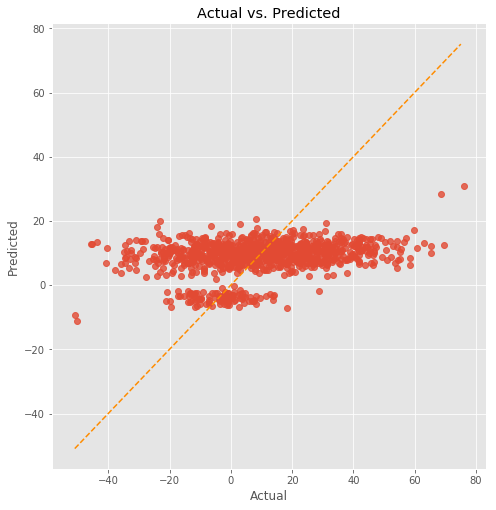

If non-linearity is apparent, consider adding a polynomial term

Assumption 2: The error terms are normally distributed

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


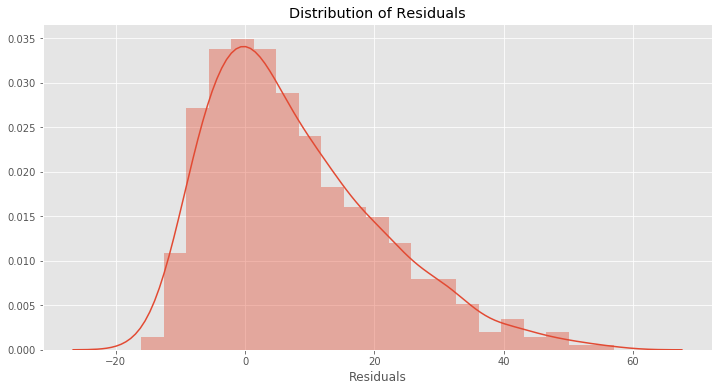


Assumption not satisfied

Confidence intervals will likely be affected
Try performing nonlinear transformations on variables

Assumption 3: Little to no multicollinearity among predictors


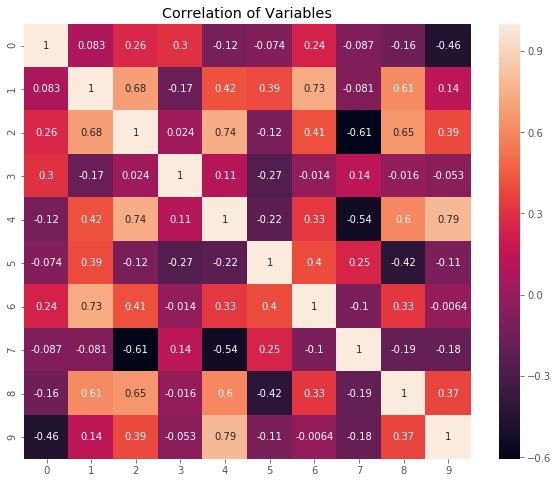

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
0: 1.795545925434981
1: 1.8692813664358667
2: 1.9118822082954492
3: 1.8191437818305807
4: 1.8848260367039664
5: 1.875668273856593
6: 1.9040254670369043
7: 1.7451967182128079
8: 1.7847908070246457
9: 1.916417172127928

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Assumption satisfied

Assumption 4: No Autocorrelation

Performing Durbin-Watson Test
Values of 1.5 < d < 2.5 generally show that there is no autocorrelation in the data
0 to 2< is positive autocorrelation
>2 to 4 is negative autocorrelation
-------------------------------------
Durbin-Watson: 1.4138415517294174
Signs of positive autocorrelation 

Assumption not satisfied 

Consider adding lag variables

Assumption 5: Homoscedasticity of Error Terms
Residuals should have relative constant variance


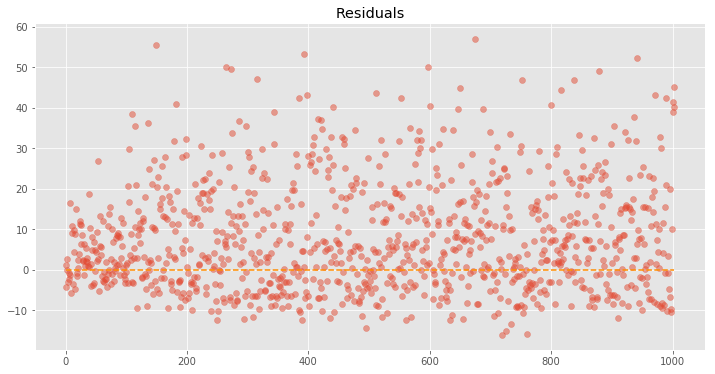

If heteroscedasticity is apparent, confidence intervals and predictions will be affected


In [57]:
linear_regression_assumptions(X,y)

<a id='step7'></a>

## Time to compare multiple regression models/techniques

Resource: https://towardsdatascience.com/5-types-of-regression-and-their-properties-c5e1fa12d55e

### Linear Regression:
- Fast and easy to model and is particularly useful when the relationship to be modeled is not extremely complex and if you don’t have a lot of data.
- Very intuitive to understand and interpret.
- Linear Regression is very sensitive to outliers.

In [58]:
# Linear regression

lrm = LinearRegression()

lrm.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lrm.predict(x_train)
y_preds_test = lrm.predict(x_test)

print("R-squared of the model in training set is: {}".format(lrm.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lrm.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in training set is: 0.07010496080907092
-----Test set statistics-----
R-squared of the model in test set is: 0.0421752270203084
Mean absolute error of the prediction is: 15.311713605472372
Mean squared error of the prediction is: 378.8727168243037
Root mean squared error of the prediction is: 19.464653010631956
Mean absolute percentage error of the prediction is: 276.2467340386921


## Ridge Regression

A standard linear or polynomial regression will fail in the case where there is high collinearity among the feature variables. Collinearity is the existence of near-linear relationships among the independent variables. The presence of hight collinearity can be determined in a few different ways:
A regression coefficient is not significant even though, theoretically, that variable should be highly correlated with Y.
When you add or delete an X feature variable, the regression coefficients change dramatically.
Your X feature variables have high pairwise correlations (check the correlation matrix).
We can first look at the optimization function of a standard linear regression to gain some insight as to how ridge regression can help:

min || Xw - y ||²

Where X represents the feature variables, w represents the weights, and y represents the ground truth. Ridge Regression is a remedial measure taken to alleviate collinearity amongst regression predictor variables in a model. Collinearity is a phenomenon in which one feature variable in a multiple regression model can be linearly predicted from the others with a substantial degree of accuracy. Since the feature variables are so correlated in this way, the final regression model is quite restricted and rigid in its approximation i.e it has high variance.
To alleviate this issue, Ridge Regression adds a small squared bias factor to the variables:

min || Xw — y ||² + z|| w ||²

Such a squared bias factor pulls the feature variable coefficients away from this rigidness, introducing a small amount of bias into the model but greatly reducing the variance.

- The assumptions of this regression is same as least squared regression except normality is not to be assumed.
- It shrinks the value of coefficients but doesn’t reaches zero, which suggests no feature selection feature

In [59]:
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(x_train)
y_preds_test = ridge_cv.predict(x_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1000.0
R-squared of the model in training set is: 0.06340557010044023
-----Test set statistics-----
R-squared of the model in test set is: 0.0541085383515122
Mean absolute error of the prediction is: 15.215726938061172
Mean squared error of the prediction is: 374.1524316403045
Root mean squared error of the prediction is: 19.34302023057166
Mean absolute percentage error of the prediction is: 262.1957015891171


In [60]:
error=0
for i in range(len(y_test)):
    error+=(abs(y_preds_test[i]-y_test[i])/y_preds_test[i])
test_error_ridge=error/len(y_test)*100
print("Test error = "'{}'.format(test_error_ridge)+" percent in Ridge Regression")

Test error = 99.79183908972496 percent in Ridge Regression


## Lasso Regression

Differences between the Ridge and Lasso regressions (L2 and L1 regularization properties):

- ***Built-in feature selection***:is frequently mentioned as a useful property of the L1-norm, which the L2-norm does not. This is actually a result of the L1-norm, which tends to produces sparse coefficients. For example, suppose the model have 100 coefficients but only 10 of them have non-zero coefficients, this is effectively saying that “the other 90 predictors are useless in predicting the target values”. L2-norm produces non-sparse coefficients, so does not have this property. Thus one can say that Lasso regression does a form of “parameter selections” since the feature variables that aren’t selected will have a total weight of 0.
- ***Sparsity:*** refers to that only very few entries in a matrix (or vector) is non-zero. L1-norm has the property of producing many coefficients with zero values or very small values with few large coefficients. This is connected to the previous point where Lasso performs a type of feature selection.
- ***Computational efficiency:*** L1-norm does not have an analytical solution, but L2-norm does. This allows the L2-norm solutions to be calculated computationally efficiently. However, L1-norm solutions does have the sparsity properties which allows it to be used along with sparse algorithms, which makes the calculation more computationally efficient.

In [61]:

lasso_cv = sklearn.linear_model.LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(x_train)
y_preds_test = lasso_cv.predict(x_test)

print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.06206642245262484
-----Test set statistics-----
R-squared of the model in test set is: 0.05264629185397385
Mean absolute error of the prediction is: 15.274646417624128
Mean squared error of the prediction is: 374.73083107078253
Root mean squared error of the prediction is: 19.3579655715879
Mean absolute percentage error of the prediction is: 261.17735313767747


In [62]:


error=0
for i in range(len(y_train)):
    error+=(abs(y_preds_train[i]-y_train[i])/y_preds_train[i])
train_error_lasso=error/len(y_train)*100

print("Train error = "'{}'.format(train_error_lasso)+" percent in Lasso Regression - Training")

error=0
for i in range(len(y_test)):
    error+=(abs(y_preds_test[i]-y_test[i])/y_preds_test[i])
test_error_lasso=error/len(y_test)*100



print("Test error = "'{}'.format(test_error_lasso)+" percent in Lasso Regression - Testing")

Train error = 244.76143593383273 percent in Lasso Regression - Training
Test error = 82.75811108861805 percent in Lasso Regression - Testing


## ElasticNetCV

ElasticNet is a hybrid of Lasso and Ridge Regression techniques. It is uses both the L1 and L2 regularization taking on the effects of both techniques:

min || Xw — y ||² + z_1|| w || + z_2|| w ||²

A practical advantage of trading-off between Lasso and Ridge is that, it allows Elastic-Net to inherit some of Ridge’s stability under rotation.

    -It encourages group effect in the case of highly correlated variables, rather than zeroing some of them out like Lasso.
    -There are no limitations on the number of selected variables.

In [63]:

elasticnet_cv = linear_model.ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(x_train)
y_preds_test = elasticnet_cv.predict(x_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(x_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(x_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.06288493441784948
-----Test set statistics-----
R-squared of the model in test set is: 0.0538432240526816
Mean absolute error of the prediction is: 15.23918069415037
Mean squared error of the prediction is: 374.2573781316106
Root mean squared error of the prediction is: 19.345732814541055
Mean absolute percentage error of the prediction is: 262.94362598354104


In [64]:
error=0
for i in range(len(y_train)):
    error+=(abs(y_preds_train[i]-y_train[i])/y_preds_train[i])
train_error_elasticnet =error/len(y_train)*100

print("Train error = "'{}'.format(train_error_elasticnet)+" ppercent in elasticnet Regression - Training")



error=0
for i in range(len(y_test)):
    error+=(abs(y_preds_test[i]-y_test[i])/y_preds_test[i])
test_error_elasticnet= error/len(y_test)*100
print("Test error = "'{}'.format(test_error_elasticnet)+" percent in elasticnet Regression - Testing")

Train error = 111.72835056006743 ppercent in elasticnet Regression - Training
Test error = 99.77207269257164 percent in elasticnet Regression - Testing


### KNN Regression

In [65]:
n_neighbors=5
knn=KNeighborsRegressor(n_neighbors,weights='uniform')
knn.fit(x_train,y_train)
y1_knn=knn.predict(x_train)
y1_knn=list(y1_knn)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_knn[i]-y_train[i])/y_train[i])
train_error_knn=error/len(y_train)*100
print("Train error = "+'{}'.format(train_error_knn)+" percent"+" in Knn algorithm")

y2_knn=knn.predict(x_test)
y2_knn=list(y2_knn)
error=0

for i in range(len(y_test)):
    error+=(abs(y2_knn[i]-y_test[i])/y_test[i])
test_error_knn=error/len(y_test)*100
print("Test error = "'{}'.format(test_error_knn)+" percent"+" in knn algorithm")

Train error = -19.73601018321053 percent in Knn algorithm
Test error = -93.34186979159136 percent in knn algorithm


## Bayes Ridge Regression

In [66]:
reg = linear_model.BayesianRidge()
reg.fit(x_train,y_train)
y1_reg=reg.predict(x_train)
y1_reg=list(y1_reg)
y2_reg=reg.predict(x_test)
y2_reg=list(y2_reg)

error=0
for i in range(len(y_train)):
    error+=(abs(y1_reg[i]-y_train[i])/y_train[i])
train_error_bay=error/len(y_train)*100
print("Train error = "+'{}'.format(train_error_bay)+" percent"+" in Bayesian Regression")

error=0
for i in range(len(y_test)):
    error+=(abs(y2_reg[i]-y_test[i])/y_test[i])
test_error_bay=(error/len(y_test))*100
print("Test error = "+'{}'.format(test_error_bay)+" percent"+" in Bayesian Regression")

Train error = -22.90069213535637 percent in Bayesian Regression
Test error = -128.66931474956317 percent in Bayesian Regression


In [67]:
train_error=[test_error_ridge,train_error_lasso,train_error_elasticnet,train_error_knn,train_error_bay]
test_error=[test_error_ridge,test_error_lasso,test_error_elasticnet,test_error_knn,test_error_bay]

col={'Train Error':train_error,'Test Error':test_error}
models=['Ridge Regression','Lasso','Elasticnet','KNN','BayesianRidge']
df_results=pd.DataFrame(data=col,index=models)
df_results

,Train Error,Test Error
Ridge Regression,99.791839,99.791839
Lasso,244.761436,82.758111
Elasticnet,111.728351,99.772073
KNN,-19.736010,-93.341870
BayesianRidge,-22.900692,-128.669315


# Testing 14 different regression techniques

In [76]:
'''Set a seed for reproducibility'''
seed = 43

'''Initialize all the regression models object we are interested in.'''
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


'''We are interested in the following 14 regression models.
All initialized with default parameters except random_state and n_jobs.'''
linear = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
kr = KernelRidge()
elnt = ElasticNet(random_state = seed)
dt = DecisionTreeRegressor(random_state = seed)
svm = SVR()
knn = KNeighborsRegressor(n_jobs = -1)
rf =  RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
xgb = XGBRegressor(random_state = seed, n_jobs = -1)
lgb = LGBMRegressor(random_state = seed, n_jobs = -1)

In [77]:
'''Training accuracy of our regression models. By default score method returns coefficient of determination (r_squared).'''
def train_r2(model):
    model.fit(x_train, y_train)
    return model.score(x_train, y_train)

'''Calculate and plot the training accuracy.'''
models = [linear, lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]
training_score = []
for model in models:
    training_score.append(train_r2(model))
    
'''Plot dataframe of training accuracy.'''
train_score = pd.DataFrame(data = training_score, columns = ['Training_R2'])
train_score.index = ['LR', 'LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
train_score = (train_score*100).round(4)
scatter_plot(train_score.index, train_score['Training_R2'], 'Training Score (R_Squared)', 'Models','% Training Score', 30, 'Rainbow')

In [78]:
'''Evaluate models on the holdout set(say on 30%).'''
def train_test_split_score(model):
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    #X_train, X_test, Y_train, Y_test = train_test_split(df_train_final, y_train, test_size = 0.3, random_state = seed)
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = np.sqrt(mse)
    return rmse

'''Calculate train_test_split score of differnt models and plot them.'''
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]
train_test_split_rmse = []
for model in models:
    train_test_split_rmse.append(train_test_split_score(model))

'''Plot data frame of train test rmse'''
train_test_score = pd.DataFrame(data = train_test_split_rmse, columns = ['Train_Test_RMSE'])
train_test_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
train_test_score = train_test_score.round(5)
x_ = train_test_score.index
y_ = train_test_score['Train_Test_RMSE']
title = "Models' Test Score (RMSE) on Holdout(30%) Set"
scatter_plot(x_, y_, title, 'Models','RMSE', 30, 'RdBu')

# K- Fold Cross Validation


train_test split has its drawbacks. Because this approach introduces bias as we are not using all of our observations for testing and also we're reducing the train data size. To overcome this we can use a technique called cross validation where all the data is used for training and testing periodically. Thus we may reduce the bias introduced by train_test_split. From different cross validation methods, we would use k-fold cross validation. In sklearn we have a method cross_val_score for calculating k-fold cross validation score.

However, as the train set gets larger, train_test_split has its advantage over k-fold cross validation. Train_test_split is k-times faster than k-fold cross validation. If the training set is very large, both train_test_split and k-fold cross validation perform identically. So for a large training data, train_test_split is prefered over k-fold cross validation to accelerate the training process.

In [81]:
'''Function to compute cross validation scores.'''
def cross_validate(model):
    from sklearn.model_selection import cross_val_score
    neg_x_val_score = cross_val_score(model, x_train, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    return x_val_score.mean()

'''Calculate cross validation score of differnt models and plot them.'''
models = [lasso, ridge, kr, elnt, dt, svm, knn, rf, et, ab, gb, xgb, lgb]
cross_val_scores = []
for model in models:
    cross_val_scores.append(cross_validate(model))

'''Plot data frame of cross validation scores.'''
x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['Cross Validation Scores (RMSE)'])
x_val_score.index = ['LSO', 'RIDGE', 'KR', 'ELNT', 'DT', 'SVM', 'KNN', 'RF', 'ET', 'AB', 'GB', 'XGB', 'LGB']
x_val_score = x_val_score.round(5)
x = x_val_score.index
y = x_val_score['Cross Validation Scores (RMSE)']
title = "Models' 10-fold Cross Validation Scores (RMSE)"
scatter_plot(x, y, title, 'Models','RMSE', 30, 'Viridis')

## Optimize Hyper Parameters

In [82]:
def grid_search_cv(model, params):
    global best_params, best_score
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(estimator = model, param_grid = params, cv = 10, verbose = 1,
                            scoring = 'neg_mean_squared_error', n_jobs = -1)
    grid_search.fit(x_train, y_train)
    best_params = grid_search.best_params_ 
    best_score = np.sqrt(-1*(np.round(grid_search.best_score_, 5)))
    return best_params, best_score

# Step 7: Craft Data Story 

Communicate results of the analysis: All the analysis and technical results that you come up with are of little value unless you can explain to your stakeholders what they mean, in a way that’s comprehensible and compelling. Data storytelling is a critical and underrated skill that you will build and use here.

<a id='step8'></a>

# Step 8: Productionize Machine Learning Model 